In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import swan_vis as swan
from scipy import sparse
import pyranges.pyranges as pr
import pyranges as pyranges
import plotly.express as px
# %matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

# Find unique intron chains, TSSs, TESs in the annotation

In [36]:
sg = swan.read('swan.p')

Read in graph from swan.p


In [37]:
paths = sg.t_df.path.values.tolist()
paths = [tuple(path[1:-1]) for path in paths]
regions = dict()
sg.t_df['intron_chain'] = paths

# add tss
paths = sg.t_df.loc_path.values.tolist()
tsss = [path[0] for path in paths]
sg.t_df['tss'] = tsss

# add tes
paths = sg.t_df.loc_path.values.tolist()
tess = [path[-1] for path in paths]
sg.t_df['tes'] = tess

# limit to annotated, non sirv or ercc genes
df = sg.t_df.loc[sg.t_df.annotation == True].copy(deep=True)

# limit to polyA genes
gene_df, _, _ = get_gtf_info(how='gene', subset='polya')
genes = gene_df.gid.tolist()
df = df.loc[df.gid.isin(genes)]

# merge tss / tes w/i 200 bp of one another
cols = ['tss', 'tes']
for c in cols:
    
    # get coords of tss / tes
    df = df.merge(sg.loc_df[['vertex_id', 'chrom', 'coord']],
                  how='left', left_on=c, right_index=True)  
    df.drop(['vertex_id'], axis=1, inplace=True)
    df.rename({'chrom': '{}_chrom'.format(c), 'coord': '{}_coord'.format(c)}, axis=1, inplace=True)

    # turn into pyranges obj
    temp = df[['gid', 'gname', '{}_coord'.format(c), '{}_chrom'.format(c), c]].copy(deep=True)
    temp.rename({'{}_coord'.format(c): 'Start',
                 '{}_chrom'.format(c): 'Chromosome'}, axis=1, inplace=True)
    temp['End'] = temp.Start
    temp_ranges = pr.PyRanges(df=temp)
        
    # cluster the starts / ends 
    temp = temp_ranges.cluster(strand=None, by=['gid', 'gname'], slack=200)
    temp = temp.as_df()
    
    # also use merge to store extra info
    temp_ranges_merge = temp_ranges.merge(strand=None, by=['gid', 'gname'], slack=200)
    temp_ranges_merge = temp_ranges_merge.as_df()
    temp_ranges_merge['len'] = temp_ranges_merge['End'] - temp_ranges_merge['Start']
    regions[c] = temp_ranges_merge

    # add to df
    temp = temp[['gid', 'gname', c, 'Cluster']]
    temp.rename({'Cluster': '{}_cluster'.format(c)}, axis=1, inplace=True)
    df = df.merge(temp, how='left', on=['gid', 'gname', c])

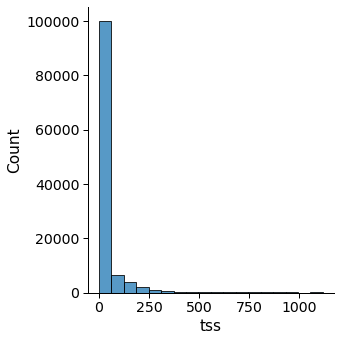

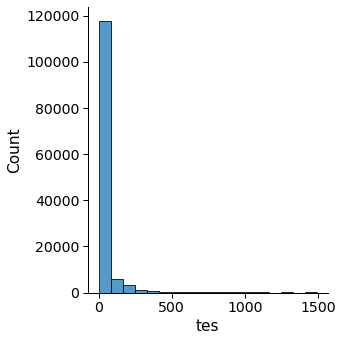

In [38]:
for c, temp in regions.items():
    ax = sns.displot(data=temp, x='len', kind='hist')
    ax.set(xlabel=c)

In [39]:
print(len(regions['tss'].loc[regions['tss'].len > 400].index))
print(len(regions['tes'].loc[regions['tes'].len > 400].index))

386
465


In [40]:
# determine the annotation status of each junction chain, tss, tes
cols = ['intron_chain', 'tss', 'tes']
for col in cols:
    known = df.loc[df.annotation == True, col].unique().tolist()
    new_col = '{}_novel'.format(col)
    df[new_col] = True
    df.loc[df[col].isin(known), new_col] = False

In [41]:
# compute # tss, # tes, # intron chains for only annotated genes
cols = ['tss_cluster', 'intron_chain', 'tes_cluster']
counts = pd.DataFrame()
for col in cols: 
    temp = df.loc[df.annotation == True].reset_index(drop=True)
    temp = temp[[col, 'gid']].groupby('gid').nunique()
    counts = pd.concat([counts, temp], axis=1)

In [42]:
# finally, compute unique combinations of tss, ic, and tes
df['tss_ic_tes'] = df.tss_cluster.astype('str')+'_'+df.intron_chain.astype('str')+'_'+df.tes_cluster.astype('str')
temp = df[['tss_ic_tes', 'gid']].groupby('gid').nunique()
counts = pd.concat([counts, temp], axis=1)

In [43]:
genes = sg.t_df[['gid', 'gname']].drop_duplicates().reset_index(drop=True)
counts = counts.merge(genes, how='left', left_index=True, right_on='gid')

In [44]:
counts.rename({'tss_cluster': 'tss', 'tes_cluster': 'tes'},
              axis=1, inplace=True)

In [45]:
counts.loc[counts.gname == 'ELN']

,tss,intron_chain,tes,tss_ic_tes,gid,gname
2645,7,34,13,34,ENSG00000049540.16,ELN


In [46]:
label_genes = ['PAX6', 'TCF4', 'MAPK10', 'ELN', 'MEF2C']

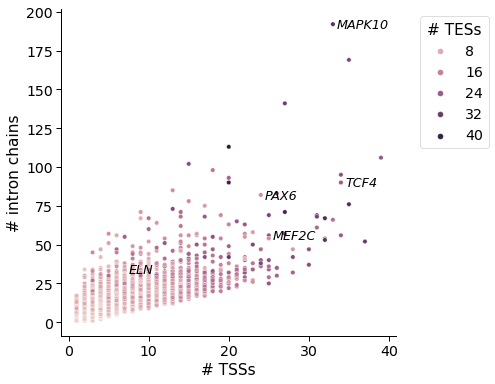

In [47]:
# plot the figure
sns.set_context('paper', font_scale=1.6)
plt.figure(figsize=(6,6))

ax = sns.scatterplot(data=counts, x='tss', y='intron_chain', hue='tes', s=20)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

xlabel = '# TSSs'
ylabel = '# intron chains'

# annotate genes that are kinda interesting
if label_genes:
    xlim = ax.get_xlim()[1]
    ylim = ax.get_ylim()[1]
    for g in label_genes:
        x = counts.loc[counts.gname == g, 'tss'].values[0]+(1/80)*xlim
        y = counts.loc[counts.gname == g, 'intron_chain'].values[0]-(1/80)*ylim
        plt.annotate(g, (x,y), fontsize='small', fontstyle='italic')

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
_ = ax.legend(title='# TESs', bbox_to_anchor=(1.05, 1))

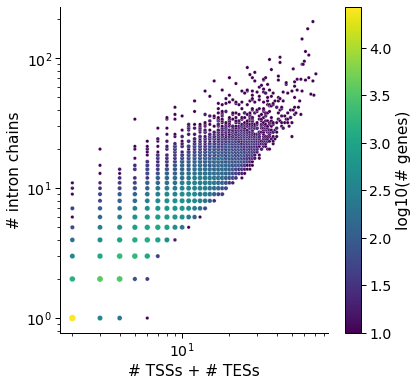

In [55]:
# plot # tss / tes vs ic, color by # genes 
counts['tss_tes'] = counts.tss+counts.tes
counts.head()

# calculate how many genes have n tss+tes and n ics
temp = counts[['tss_tes', 'intron_chain', 'gid']].groupby(['tss_tes', 'intron_chain']).count().reset_index()
temp.rename({'gid': 'n_genes'}, inplace=True, axis=1)
temp['log10_n_genes'] = np.log10(temp.n_genes)

# plot the figure
sns.set_context('paper', font_scale=1.6)
plt.figure(figsize=(6,6))

# ax = sns.scatterplot(data=temp, x='tss_tes', y='intron_chain', hue='n_genes', size='n_genes', palette='viridis')
ax = sns.scatterplot(data=temp, x='tss_tes', y='intron_chain', hue='log10_n_genes', size='log10_n_genes', palette='viridis')


norm = plt.Normalize(temp['n_genes'].min(), temp['log10_n_genes'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
cb = ax.figure.colorbar(sm)
cb.set_label('log10(# genes)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

xlabel = '# TSSs + # TESs'
ylabel = '# intron chains'

_ = ax.set(xlabel=xlabel, ylabel=ylabel, xscale='log', yscale='log')

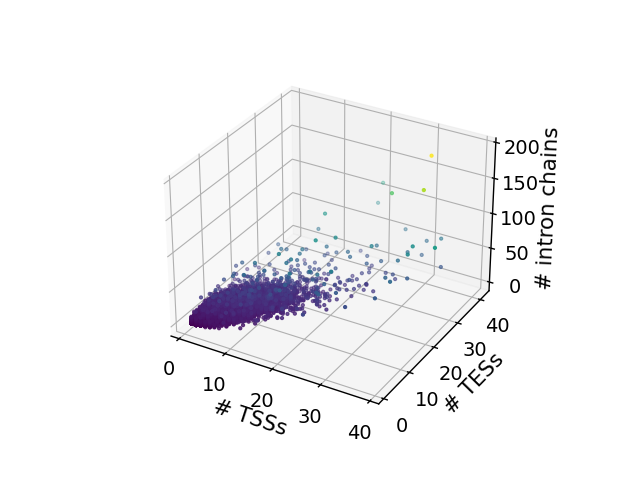

In [75]:
# label_genes = ['ELN', 'MAPK10']

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = counts['tss']
y = counts['tes']
z = counts['intron_chain']
c = counts['tss_ic_tes']

ax.set_xlabel('# TSSs')
ax.set_ylabel('# TESs')
ax.set_zlabel('# intron chains')

ax.scatter(x, y, z, c=c, s=5)
plt.show()

In [16]:
# fig = px.scatter_3d(counts, x='tss', y='intron_chain', z='tes', color='tss_ic_tes')
# fig.show()


## Properties of introns in gtf

In [36]:
gtf = pyranges.read_gtf('../../refs/gencode_v29_sirv4_ercc.gtf')
gtf.head()
temp = gtf.as_df()
temp.head()
temp.columns
introns = gtf.features.introns()
introns.lengths()
lens = introns.lengths()
gtf = gtf[gtf.gene_type == 'protein_coding']
introns = gtf.features.introns()
lens = introns.lengths()
ax = sns.displot(x=lens, kind='hist')
ax.set(xlim=(0,10000))
print(temp['len'].max())
temp.loc[temp['len'].idxmin()]
temp = temp.merge(sg.loc_df[['coord']], how='left', left_on='tss', right_index=True)
temp.loc[temp.gname=='ELN']